In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))


(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)


Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
8281000
Data shapes: 1450.0 200.0


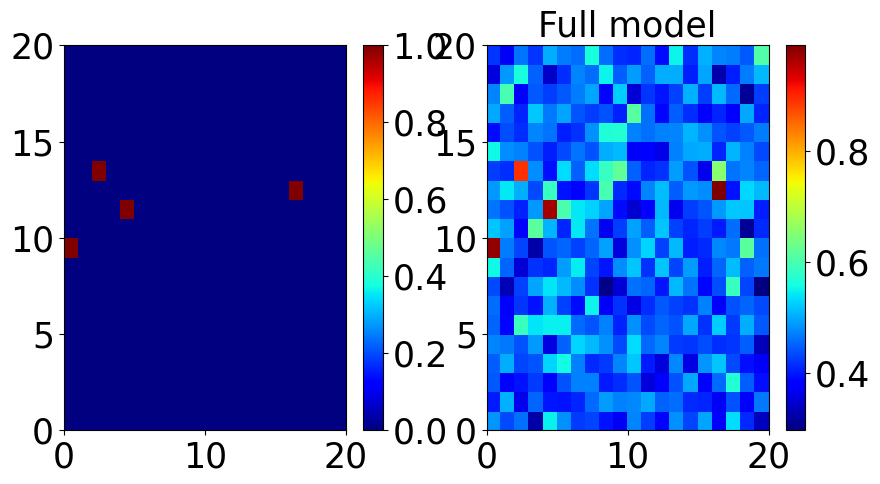

time for labeled: 13.193795680999756


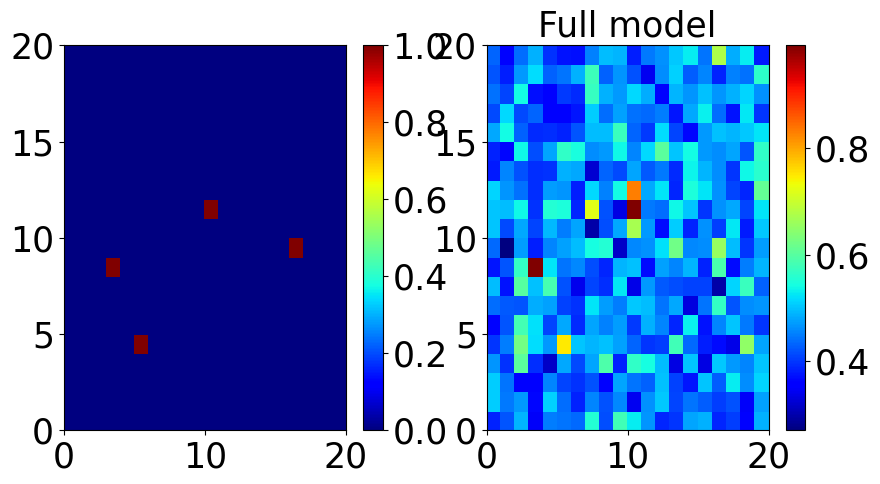

In [4]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=10
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
22014000
Data shapes: 725.0 200.0
epoch: 0, train loss: 6.430013179779053
epoch: 1, train loss: 6.494762420654297
epoch: 2, train loss: 5.44972038269043
epoch: 3, train loss: 4.0391058921813965
epoch: 4, train loss: 3.1831438541412354
epoch: 5, train loss: 2.64935302734375
epoch: 6, train loss: 2.285841703414917
epoch: 7, train loss: 2.0200891494750977
epoch: 8, train loss: 1.8212798833847046
epoch: 9, train loss: 1.6505944728851318
epoch: 10, train loss: 1.5108561515808105
epoch: 11, train loss: 1.3896347284317017
epoch: 12, train loss: 1.3056507110595703
epoch: 13, train loss: 1.316625952720642
epoch: 14, train loss: 1.3470993041992188
epoch: 15, train loss: 1.2161540985107422
epoch: 16, train loss: 1.2034775018692017
epoch: 17, train loss: 1.2210596799850464
epoch: 18, tra

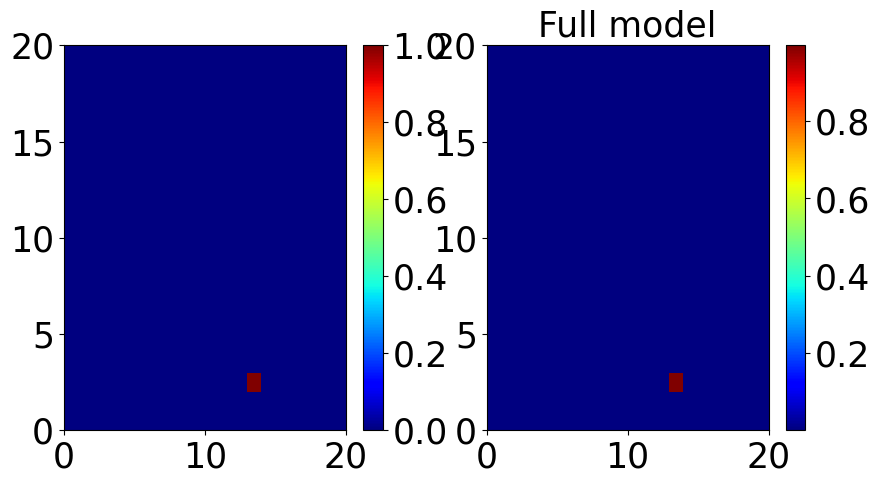

time for labeled: 1505.110282421112
epoch: 199, train loss: 0.005938134156167507


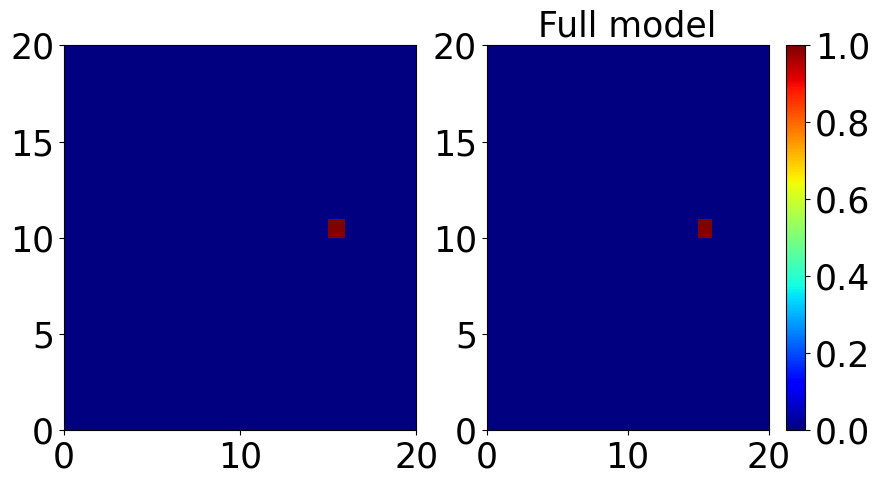

val loss: 0.006452071014791727


In [2]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=400
layer_loss_list=[]
Epochs=200
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
        bce_loss.backward() 
        train_lossavg+=bce_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    print(f'epoch: {epoch}, train loss: {train_lossavg}')
val_loss=0
encoder.eval()
for batch, (b,rho,num_targets) in enumerate(valloader):
    b=b.to(device)
    rho=rho.to(device)    
    font_size = 50
    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()/len(valloader)
    if batch==0:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)

torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer.pt')

torch.save(encoder.state_dict(), 'encoder.pth')
wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [2]:

layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_20000U_[500, 500, 500, 300, 300, 400, 800]_16-May-2024 (10:31:06)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_16-May-2024 (19:56:07)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_10000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (16:35:12)decoder.pt'
#locat='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)

Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 12124.0 400.0
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(12124,) (400, 12124)
torch.Size([400, 24248])
torch.Size([400, 400])
(400, 1450) (400, 1450)


In [6]:
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(10):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)


0.2079180803218133


KeyboardInterrupt: 

In [47]:
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


0.9935132860014338


In [16]:
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat1='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
locat2='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (10:33:30)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (07:51:38)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (02:50:48)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
for j in range(5):
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    larger_than=0
    sum_max_noreplace_original=0
    for i in range(400):
        if max(torch_inners[i,:])>.90:
            larger_than+=1
            total_list[j].append(i)
        sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
    print(larger_than)    


399
0
27
6
82


In [20]:
total_list[-3], total_list[-1]
shared_inds=set(total_list[-3]).intersection(total_list[-1])
shared_inds

{38, 117, 134, 393}

0.9954802301497007
(1450, 400)


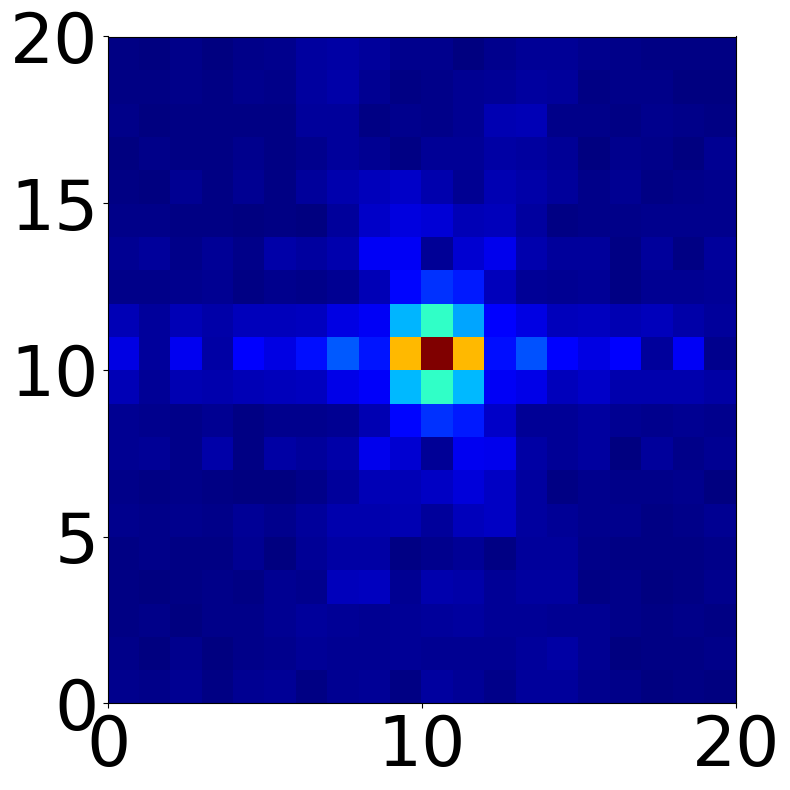

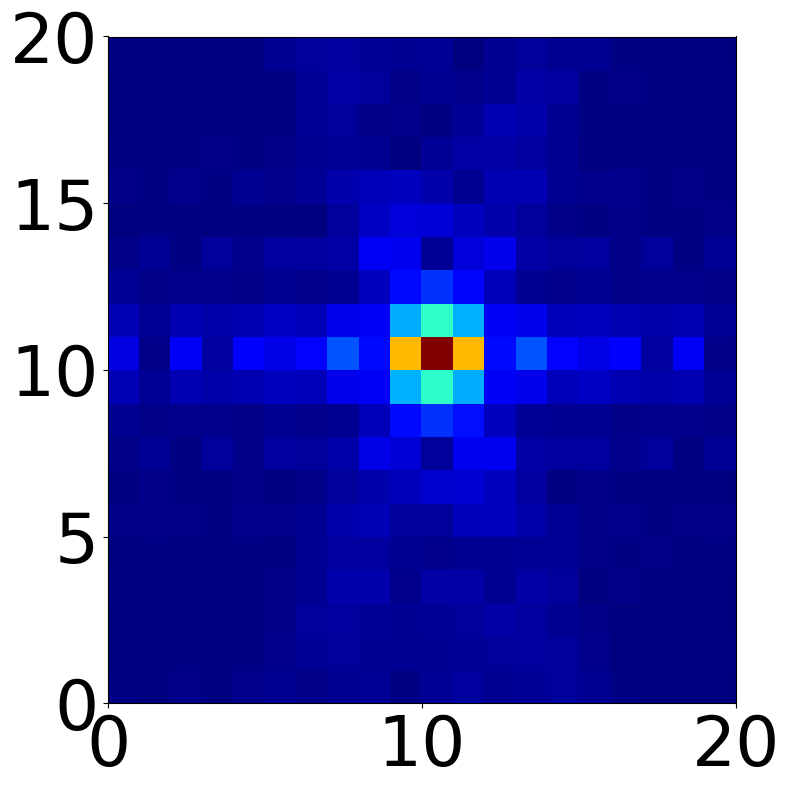

: 

In [24]:
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False):
    plt.close()

    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol2=ax.pcolor(output,cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[210]=1
#rho[0]=1

KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat_KM')
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho_KM')

In [305]:
orderer

fc_net_batch(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): linear_layer_wrapper(
      (layer): Sequential(
        (0): Linear(in_features=24248, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
      )
    )
    (1): linear_layer_wrapper(
      (layer): Sequential(
        (0): Linear(in_features=500, out_features=2000, bias=True)
        (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
      )
    )
    (2): linear_layer_wrapper(
      (layer): Sequential(
        (0): Linear(in_features=2000, out_features=1500, bias=True)
        (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
      )
    )
    (3): linear_layer_wrapper(
    

In [17]:

torch_inners=np.inner(medium_hat,medium.T.conj())
torch_inners=np.abs(torch_inners)
larger_than=0
sum_max_noreplace_original=0
for i in range(400):
    if max(torch_inners[i,:])>.95:
        larger_than+=1
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat

avg_max_inners_original=sum_max_noreplace_original/400
larger_than

18

In [335]:
stupid=torch.tensor([[8,5],[6,7]]).float()
print(stupid.shape)
torch.max(stupid, -1), softmax(stupid)

torch.Size([2, 2])


(torch.return_types.max(
 values=tensor([8., 7.]),
 indices=tensor([0, 1])),
 tensor([[0.9526, 0.0474],
         [0.2689, 0.7311]]))

In [350]:
torch_inners=np.inner(G_hat_permed,medium.T.conj()).diagonal()
torch_inners_abs=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners_abs.diagonal())/400)
Inners=torch_inners_abs.diagonal()
print(np.mean(Inners[Inners<.90]))
print(len(torch_inners[torch_inners.imag<0]))



0.9596838087513345
0.46775846488162337
206


In [357]:
MINI_g_hat_permed=G_hat_permed[Inners<.90]

Mini_medium=medium.T[Inners<.90]
mini_torch_inners=np.inner(MINI_g_hat_permed,Mini_medium.conj())

In [359]:
torch_inners=np.inner(medium_hat,medium.T.conj())
torch_inners=mini_torch_inners
torch_inners=np.abs(torch_inners)
print(torch_inners[0][0], np.inner(medium_hat,medium.T.conj())[0][0])
sum_max_noreplace_original=0
for i in range(len(MINI_g_hat_permed)):
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat

avg_max_inners_original=sum_max_noreplace_original/len(MINI_g_hat_permed)
avg_max_inners_original


0.5342909769682898 (-0.007283001866946109+0.004790117186453246j)


0.5128090779007499

In [ ]:
#loads model from location and gets Ghat error
data_path='/home/achristie/Codes_data/PNAS-regime_all_seeds/PNAS-regime_seed0'
location='/home/achristie/Codes_data/Experiment_data/Complex_tests/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_06-May-2024 (14:12:11)decoder.pt'
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(location))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj(), ).diagonal())
mean_inn_product=np.mean(torch_inners)
print(mean_inn_product)


0.1661837688155095


In [ ]:
layers=[500,500, 500, 300, 300, 400,800]
softmax=nn.Softmax(dim=1)
Orderer=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
locat="/home/achristie/Codes_data/Experiment_data/hom/5000L_0U_[500, 500, 500, 300, 300, 400, 800]_13-May-2024 (13:14:58)"
Orderer.load_state_dict(torch.load(locat+'encoder.pt'))
decoder_locat="/home/achristie/Codes_data/Experiment_data/Long_best_exps/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_12-May-2024 (11:03:02)decoder.pt"
Orderer.eval()
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(decoder_locat))
decoder_weights=decoder.weight.cpu().detach().numpy().T
decoder_weights=torch.tensor(decoder_weights)
decoder_weights=F.normalize(decoder_weights, dim=-1)
perm=Orderer(decoder_weights)

#gotta confirm outscaling is the same
perm=(softmax(perm))
largest,indices=torch.max(perm, -1)
perm_mat=torch.zeros(perm.shape)
for i in range(len(perm)):
    perm_mat[i, indices[i]]=1

perm_mat=perm_mat.cpu().detach().numpy()
medium_hat=H.cat2complex(decoder_weights.cpu().detach().numpy())
medium_hat_permed=(medium_hat.T@np.linalge.inv(perm_mat)).T
medium_hat_permed=F.normalize(torch.tensor(medium_hat_permed), dim=-1).numpy()
#medium_hat_inverse_permed=(medium_hat.T@np.linalg.inv(perm_mat.T)).T



max_inners_1=0
torch_inners=np.abs(np.inner(medium_hat_permed.squeeze(),medium.T.conj()))
for i in range(int(200*2)):
    max_inners_1=max_inners_1+max(torch_inners[:,i]) #Fix g, find max over ghat

max_inners_1=max_inners_1/(int(200*2))


print(max_inners_1)


0.6716700740174152


In [ ]:
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()



        #self.Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])


In [ ]:
np.sort(outer[0].real, cc

((0.0050157915875806425+0j), (0.0007125699727423029-0.0022415345257136435j))

In [ ]:
outer.shape, cc.shape

((12124,), (12124,))

In [ ]:
np.allclose(outer,cc)

True

(2900, 2900)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2900 but corresponding boolean dimension is 1450

In [ ]:
class data_rho_CC:
    def __init__(self,data_path ,prop,sparsity=4):
        if 'PNAS' in data_path and "train" in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-5],int(80000*prop), S=sparsity,seed=0)
            self.data_path=data_path[:-5]

        elif 'PNAS' in data_path and 'val' in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-3],3000, S=sparsity,seed=100)
            self.data_path=data_path[:-3]
        self.Mask=np.array(mat73.loadmat(self.data_path+'/M.mat')['M'])
        
    def __len__(self):
        return(int(len(self.b)))

    def __getitem__(self, idx):
        outer=np.outer(self.b[idx,...],self.b[idx,...].conj())
        outer=outer[abs(self.Mask)>0]
        outer=outer.ravel()

        return torch.cat((torch.tensor(outer.real),torch.tensor(outer.imag)),dim=-1).float(),self.rho[idx,...].float(), float(torch.sum(self.rho[idx,...].real))
        
training_data[0]


Medium: (1450, 400), Rho: (50000, 400), B: (50000, 1450)


In [ ]:
training_data[0].shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
training_data=H.data_rho_CC(data_path+'/train',500/80000,1)
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
b=training_data.b[0]
outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()
outer[5],training_data[0][0][5].numpy().item()


Medium: (1450, 400), Rho: (500, 400), B: (500, 1450)


((0.000689655172413793+0j), 0.0006896551931276917)

In [ ]:
reppeated=np.sort(indices.numpy())
dum=[]
num=0
for i in range(len(reppeated)):
    
    if reppeated[i] not in dum:
        dum.append(reppeated[i])
    else:
        num=num+1
num  



17

In [62]:
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
torch_inners=torch_inners[ghat_indices,:]
#sum(torch_inners.diagonal()[torch_inners.diagonal()<.99])/29

sum_max_noreplace_original=0
for i in range(29):
    sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[i,:]) #Fix g, find max over ghat
sum_max_noreplace_original/29

0.7431269188186671

In [67]:
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
ghat_indices=[]
bad_inners=0
for i in range(len(torch_inners)):
    if torch_inners[i,i]<.99:
        ghat_indices.append(i)
        print(i, torch_inners[i,i])
        bad_inners=bad_inners+torch_inners[i,i]
print(bad_inners/29)

6 0.5342909769682892
46 0.405986573962857
60 0.4022766454086502
71 0.5174038937764768
80 0.2721817373039107
105 0.4033641016939844
118 0.41787379474864855
123 0.4046924205362258
134 0.9261311687417683
140 0.40309098806550514
146 0.5446569336303733
154 0.24441555373283624
171 0.5468717054074038
174 0.8762792783256489
180 0.5239835144047388
192 0.5328142370454755
194 0.20250661515005108
199 0.1831513222328974
205 0.5463134233277359
214 0.5520814349405198
219 0.4263786647009856
234 0.9094268687808801
238 0.36115683740556914
243 0.543271288258382
258 0.15743266165122308
268 0.5514944574463213
269 0.5435001067892222
308 0.5475227477244299
323 0.4019080267904057
0.47870544755004873


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 200.0
22013200
Data shapes: 725.0 200.0
epoch: 0, train loss: 0.000900185783393681
epoch: 1, train loss: 16.737476348876953
epoch: 2, train loss: 6.217289924621582
epoch: 3, train loss: 4.878556251525879
epoch: 4, train loss: 3.216585397720337
epoch: 5, train loss: 2.5261337757110596
epoch: 6, train loss: 2.367039203643799
epoch: 7, train loss: 2.0562024116516113
epoch: 8, train loss: 1.7253530025482178
epoch: 9, train loss: 1.5832865238189697
epoch: 10, train loss: 1.4248408079147339
epoch: 11, train loss: 1.2203185558319092
epoch: 12, train loss: 1.0965123176574707
epoch: 13, train loss: 1.0027754306793213
epoch: 14, train loss: 0.9118785858154297
epoch: 15, train loss: 0.8362675309181213
epoch: 16, train loss: 0.7518928647041321
epoch: 17, train loss: 0.

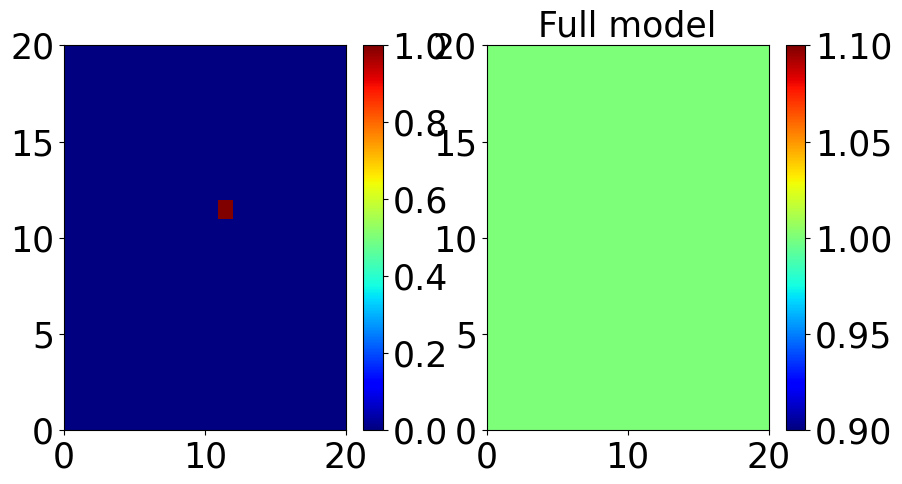

time for labeled: 12947.463341712952
epoch: 1999, train loss: 3.4641278034541756e-05


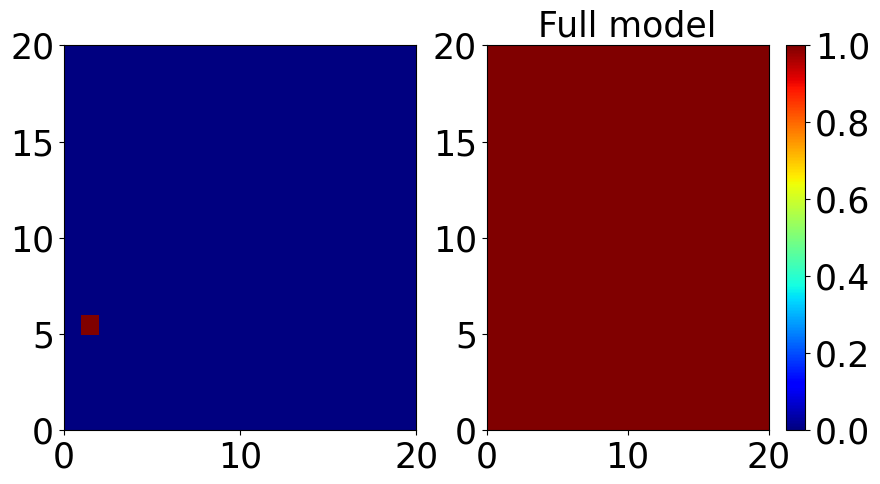

val loss: 5.63988542126026e-05


In [360]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=400
layer_loss_list=[]
Epochs=2000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
Locat='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
encoder.load_state_dict(torch.load(Locat))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
        bce_loss.backward() 
        train_lossavg+=bce_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    print(f'epoch: {epoch}, train loss: {train_lossavg}')
val_loss=0
encoder.eval()
for batch, (b,rho,num_targets) in enumerate(valloader):
    b=b.to(device)
    rho=rho.to(device)    
    font_size = 50
    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()/len(valloader)
    if batch==0:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)

torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


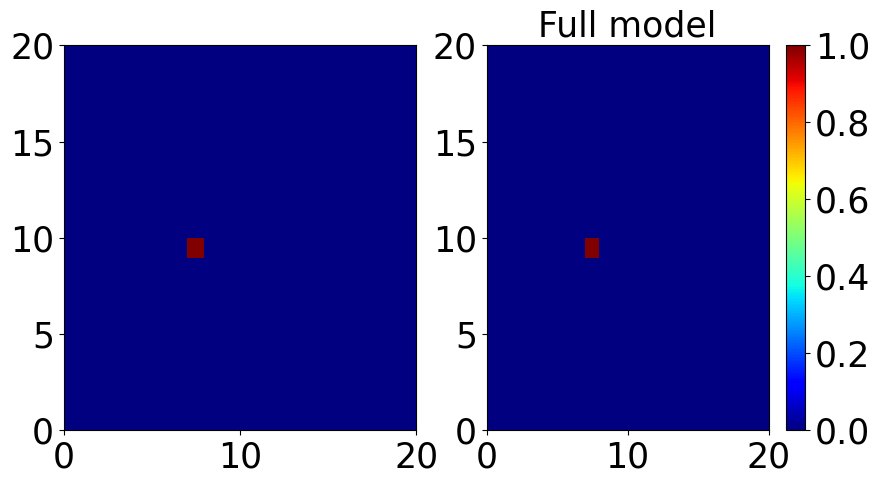

In [ ]:
softmax=nn.Softmax(dim=1)
H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
